# Identifying Stability in Indian Carnatic Music
March 2021

We want to exclude patterns that contian a large proportion of stable regions (i.e. held notes). Regions of held notes are likely to match highly in similarity with each other but are not that interesting from a musicological perspective.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('../')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.use('TkAgg')

import os
import sys
import numpy as np
from scipy.ndimage import gaussian_filter1d
import mirdata
import essentia.standard as estd

from spleeter.separator import Separator
from spleeter.audio.adapter import AudioAdapter
import stumpy 

from src.utils import get_timestamp, interpolate_below_length
from src.visualisation import plot_all_sequences, double_timeseries, plot_subsequence
from src.iam import unpack_saraga_metadata
from src.io import write_all_sequence_audio, write_json, load_annotations, load_json, load_yaml, load_tonic
from src.sequence import contains_silence, too_stable
from src.motif import get_motif_clusters, get_exclusion_mask
from src.pitch import cents_to_pitch

## 1. Load Recording and Metadata

Path to recording directory in `mir_datasets` (downloaded from - https://github.com/mir-dataset-loaders/mirdata)

In [2]:
mir_datasets_dir = '/Users/thomasnuttall/mir_datasets/saraga_carnatic/saraga1.5_carnatic/'

Path to recording and metadata

In [3]:
# Akkarai Sisters - Koti Janmi
recording_dir = "Akkarai Sisters at Arkay by Akkarai Sisters/Koti Janmani/"

audio_file = "Koti Janmani.multitrack-vocal.mp3"
metadata_file = "Koti Janmani.json"
tonic_file = "Koti Janmani.ctonic.txt"

audio_path = os.path.join(mir_datasets_dir, recording_dir, audio_file)
metadata_path = os.path.join(mir_datasets_dir, recording_dir, metadata_file)
tonic_path = os.path.join(mir_datasets_dir, recording_dir, tonic_file)

# # Salem Gayatri Venkatesan - Sharanu Janakana
# recording_dir = "Salem Gayatri Venkatesan at Arkay by Salem Gayatri Venkatesan/Sharanu Janakana/"

# # Akkarai Sisters - Shankari Shankuru
# recording_dir = "Akkarai Sisters at Arkay by Akkarai Sisters/Shankari Shankuru/"

# # Cheerthala Ranganatha Sharma - Karuna Nidhi Illalo
# recording_dir = "Cherthala Ranganatha Sharma at Arkay by Cherthala Ranganatha Sharma/Karuna Nidhi Illalo/"

In [4]:
metadata = load_json(metadata_path)
tonic = load_tonic(tonic_path)

Expected svara-cent mapping (this is used as a guide for plotting only, variation is expected)

In [5]:
svara_cent_path = "../conf/svara_cents.yaml"
svara_freq_path = "../conf/svara_lookup.yaml"

In [6]:
svara_cent = load_yaml(svara_cent_path)
svara_freq = load_yaml(svara_freq_path)

Extract metadata

In [7]:
raaga, taala, album_artists, concert, title, length, arohana, avorahana = unpack_saraga_metadata(metadata, svara_freq)

In [8]:
print(f'Concert: {concert}')
print(f'Title: {title}')
print(f'Artist: {album_artists}')
print(f'Raaga: {raaga}')
print(f'Taala: {taala}')
print(f'Arohana: {arohana}')
print(f'Avorahana: {avorahana}')
print(f'Tonic: {tonic} Hz')
print(f'Performance Length: {length}')

Concert: Akkarai Sisters at Arkay
Title: Koti Janmani
Artist: Akkarai Sisters
Raaga: Rītigauḷa
Taala: Miśra chāpu
Arohana: None provided
Avorahana: None provided
Tonic: 130.059356 Hz
Performance Length: 526706


## 2. Predominant Pitch Extraction

In [9]:
sampling_rate = 44100
frameSize = 2048 # For Melodia pitch extraction
hopSize = 128 # For Melodia pitch extraction
gap_interp = 250*0.001 # Interpolate pitch tracks gaps of <gap_interp>seconds or less [set to None to skip]
smooth = 7 # sigma for gaussian smoothing of pitch track [set to None to skip]

In [10]:
# Run spleeter on track to remove the background
separator = Separator('spleeter:2stems')
audio_loader = AudioAdapter.default()
waveform, _ = audio_loader.load(audio_path, sample_rate=sampling_rate)
prediction = separator.separate(waveform=waveform)
clean_vocal = prediction['vocals']

INFO:tensorflow:Apply unet for vocals_spectrogram


[2021-06-01 15:23:49,785] INFO [tensorflow.apply_unet:100] Apply unet for vocals_spectrogram


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[2021-06-01 15:23:49,801] WARNING [tensorflow.new_func:500] From /Users/thomasnuttall/.virtualenvs/CMMR/lib/python3.8/site-packages/tensorflow/python/ops/resource_variable_ops.py:1659: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Apply unet for accompaniment_spectrogram


[2021-06-01 15:23:50,513] INFO [tensorflow.apply_unet:100] Apply unet for accompaniment_spectrogram


INFO:tensorflow:Restoring parameters from pretrained_models/2stems/model


[2021-06-01 15:23:53,609] INFO [tensorflow.restore:1293] Restoring parameters from pretrained_models/2stems/model


In [11]:
# Prepare audio for pitch extraction
audio_mono = clean_vocal.sum(axis=1) / 2
audio_mono_eqloud = estd.EqualLoudness(sampleRate=sampling_rate)(audio_mono)

# Extract pitch using Melodia algorithm from Essentia
pitch_extractor = estd.PredominantPitchMelodia(frameSize=frameSize, hopSize=hopSize)
raw_pitch, _ = pitch_extractor(audio_mono_eqloud)
raw_pitch = np.append(raw_pitch, 0.0)
time = np.linspace(0.0, len(audio_mono_eqloud) / sampling_rate, len(raw_pitch))

timestep = time[4]-time[3] # resolution of time track

In [25]:
# Gap interpolation
if gap_interp:
    raw_pitch = interpolate_below_length(raw_pitch, 0, int(gap_interp)/timestep)
    
# Gaussian smoothing
if smooth:
    pitch = gaussian_filter1d(raw_pitch, smooth)
else:
    pitch = raw_pitch[:]

## 3. Stability Regions

A region is defined as stable if the average absolute deviation from the mean in that region is below some threshold. 

We compute this deviation repeatedly for a rolling window (size=`window`) across the sequence. Sequences that contain a proportion greater than `perc_thresh` of windows that have an average absolute deviation from the mean of below `dev_thresh` are discarded.

`window`, `dev_thresh` and `perc_thresh` are chosen subjectively based on the plots below

In [30]:
window = 200
perc_thresh = 0.63
dev_thresh = 5

l = 1700
print(f'Window = {round(window*timestep,2)} seconds')
print(f'Pattern Length = {round(l*timestep,2)} seconds')

Window = 0.58 seconds
Pattern Length = 4.93 seconds


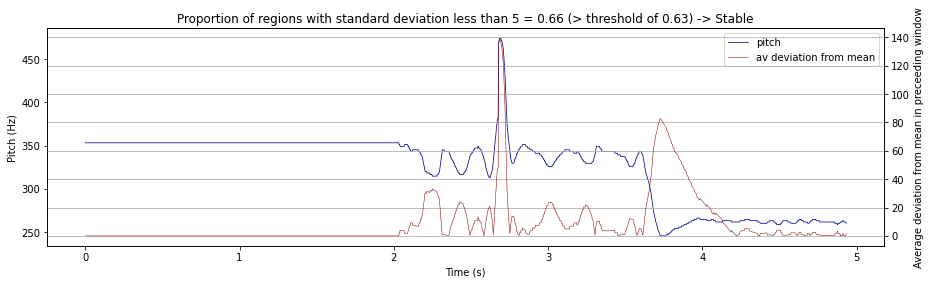

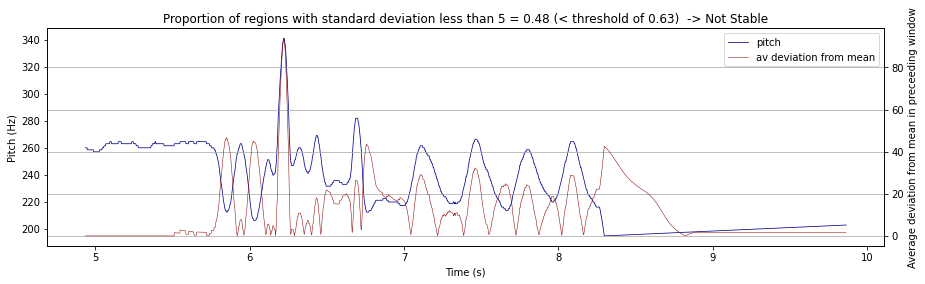

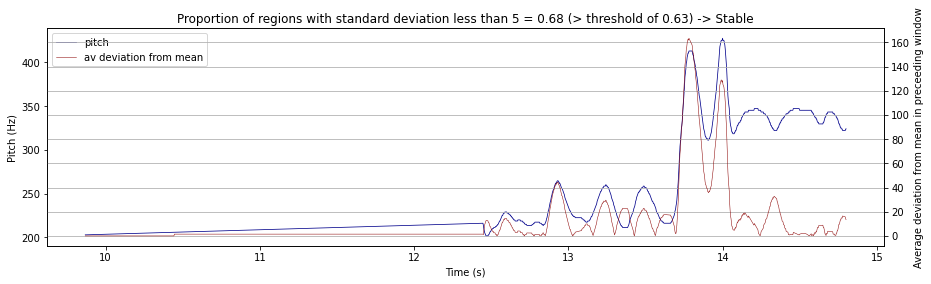

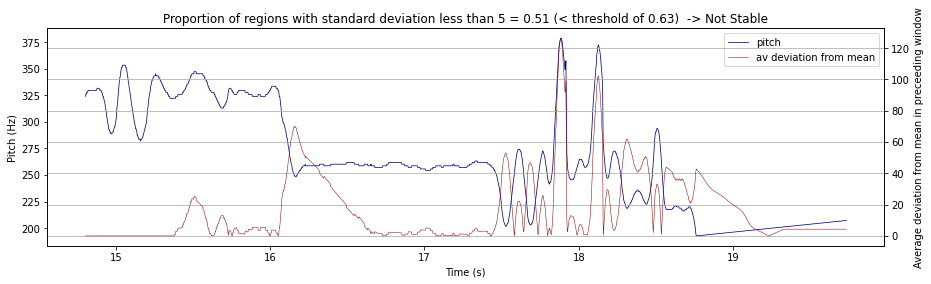

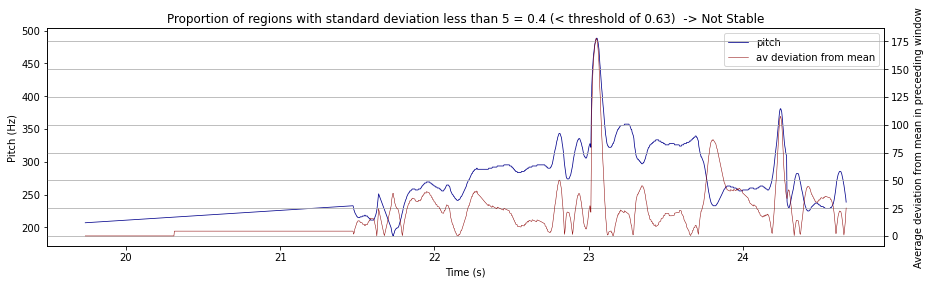

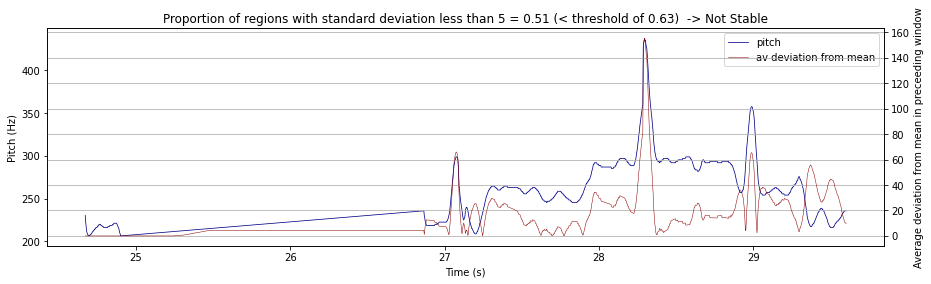

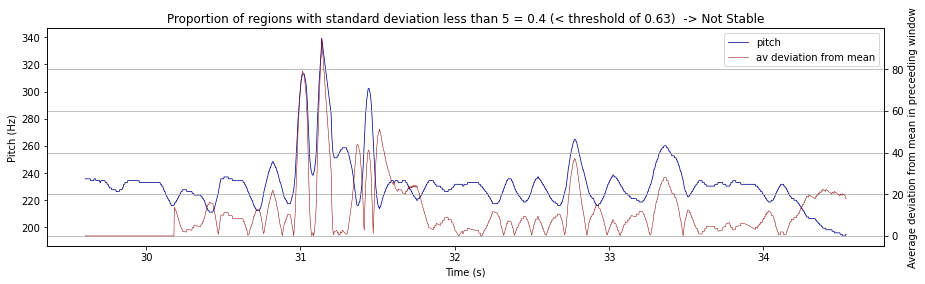

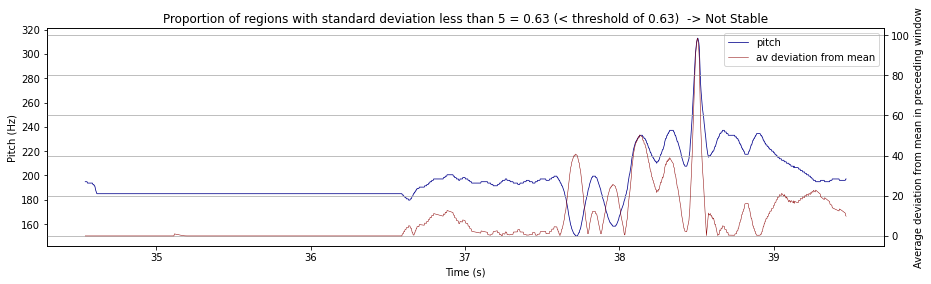

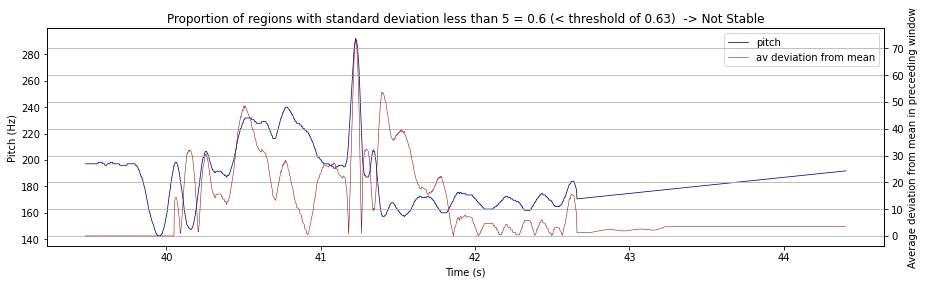

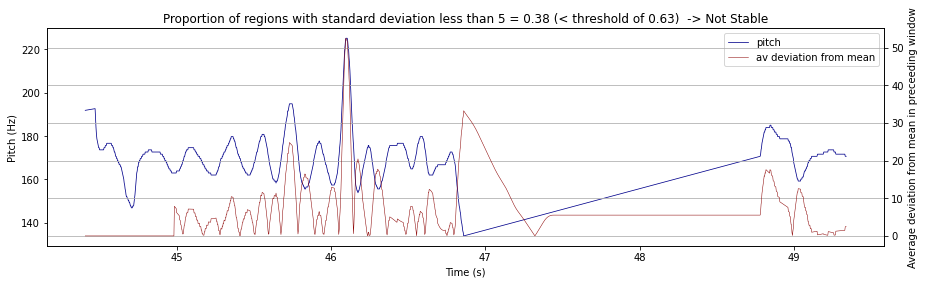

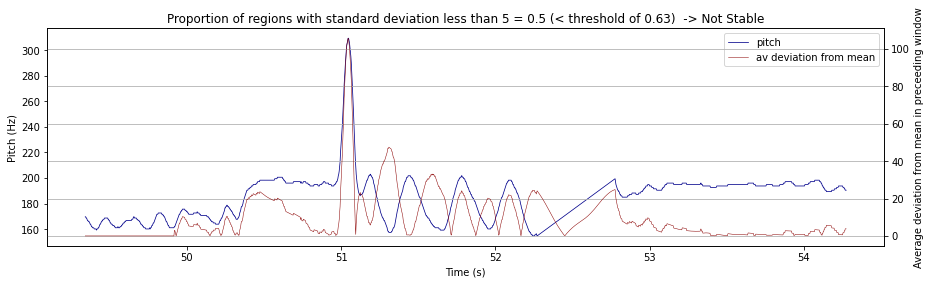

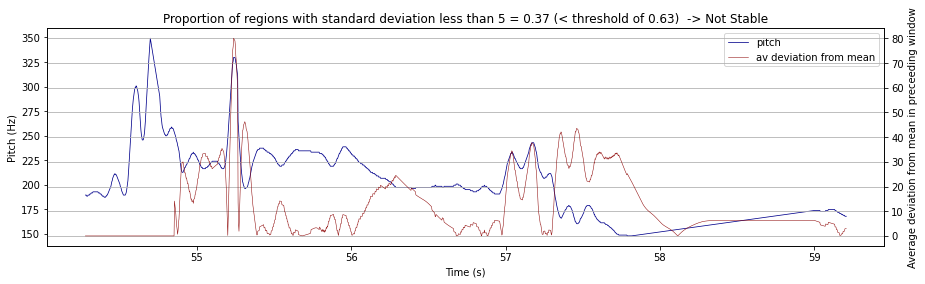

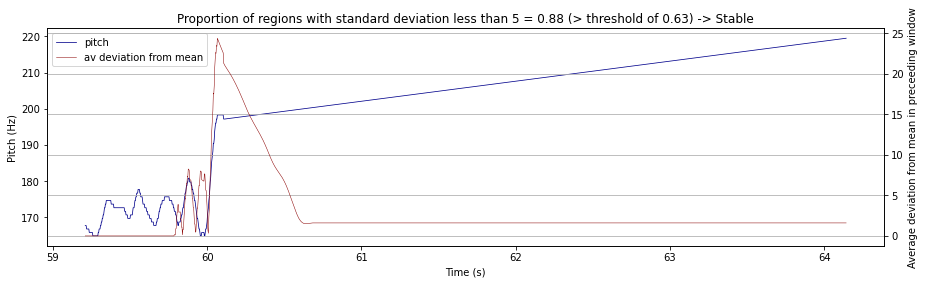

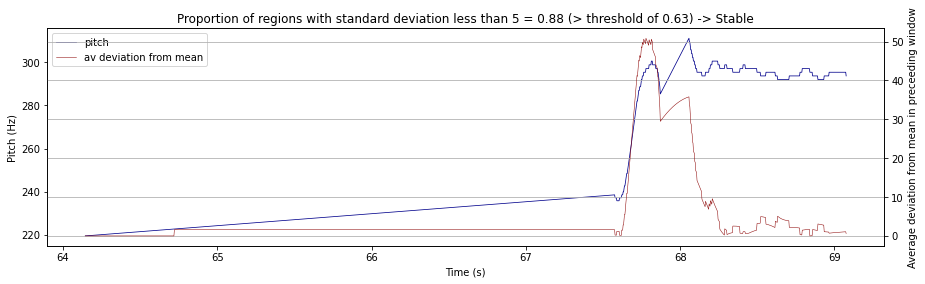

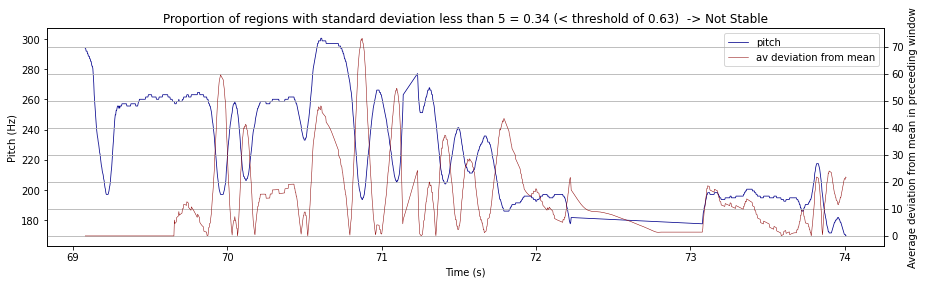

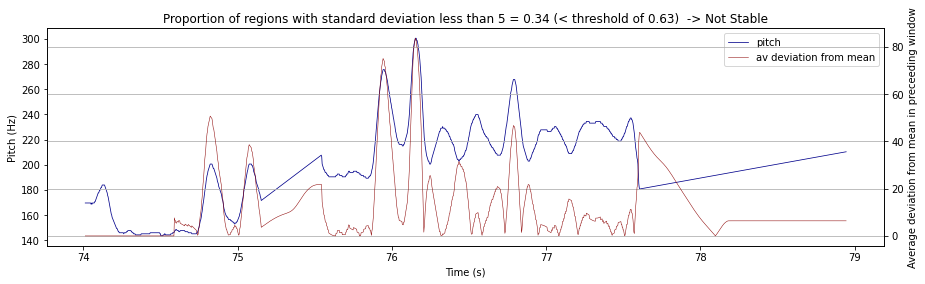

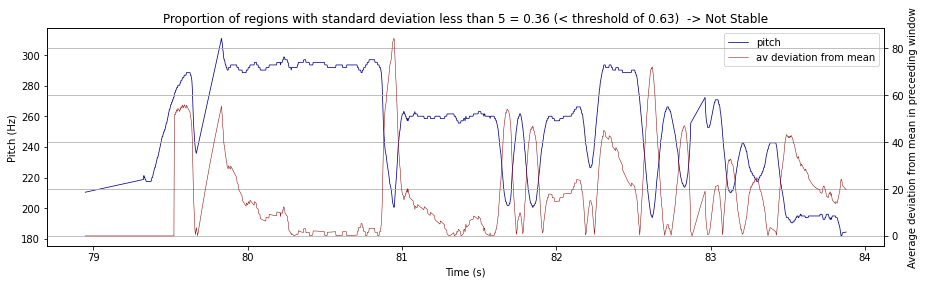

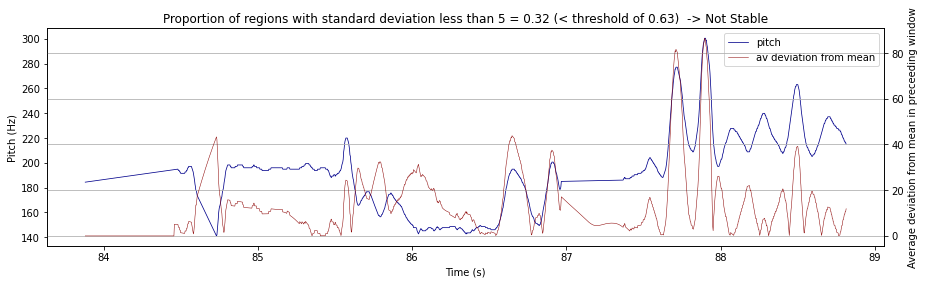

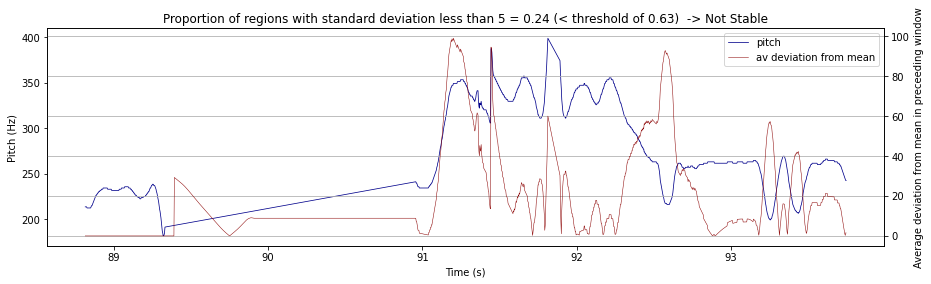

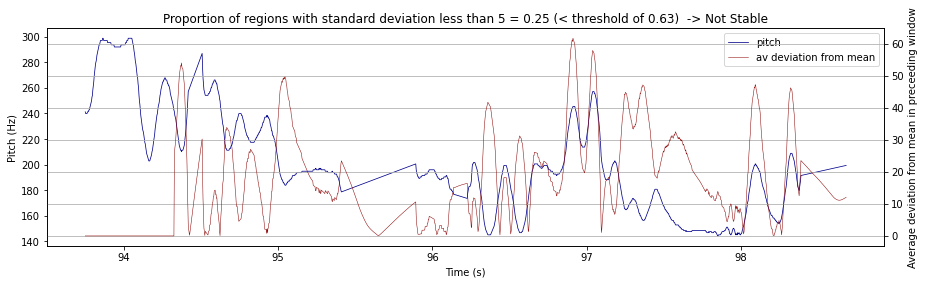

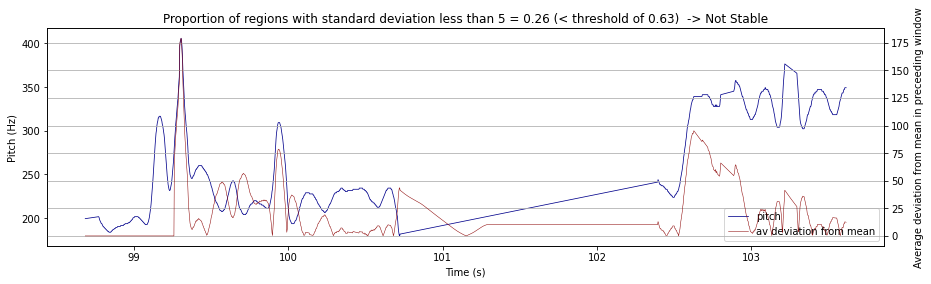

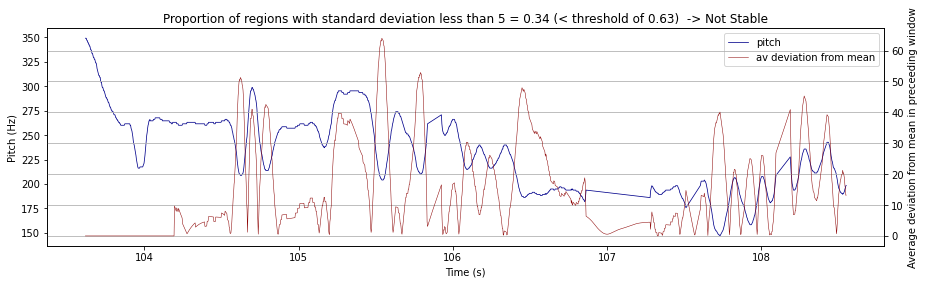

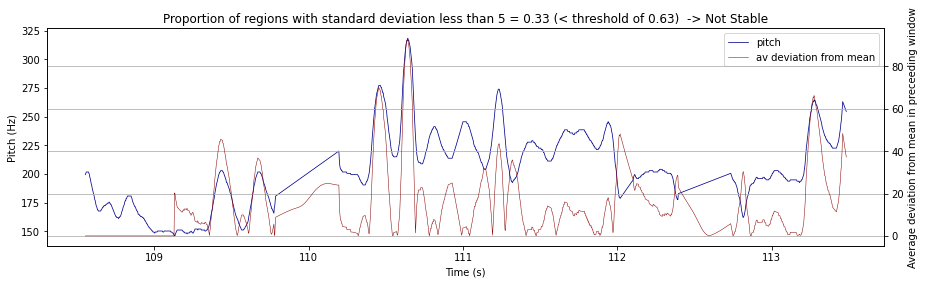

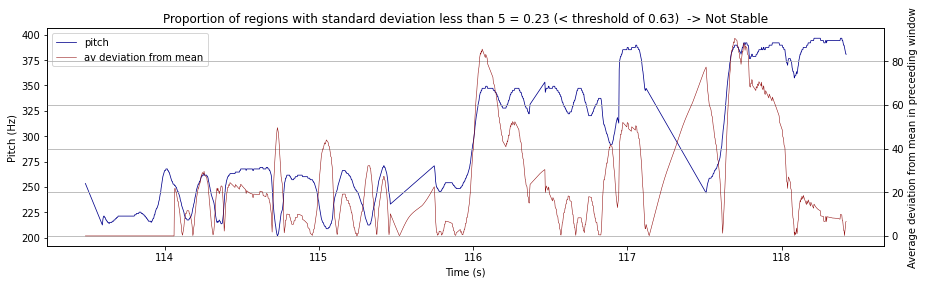

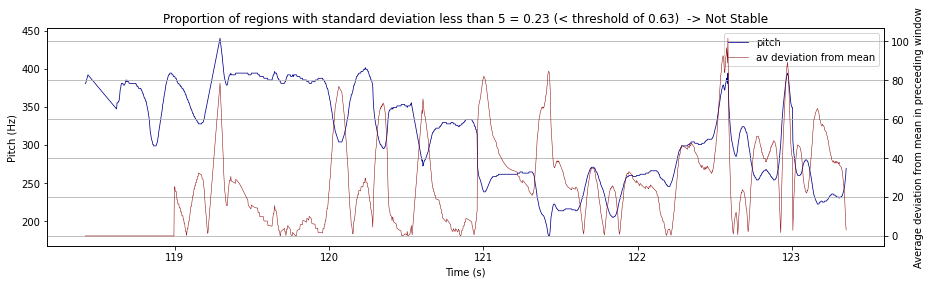

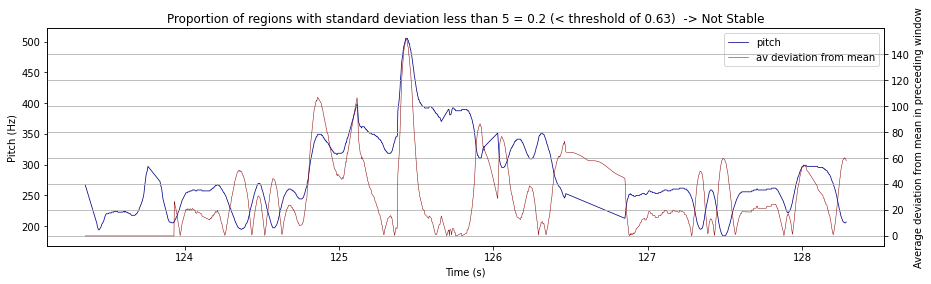

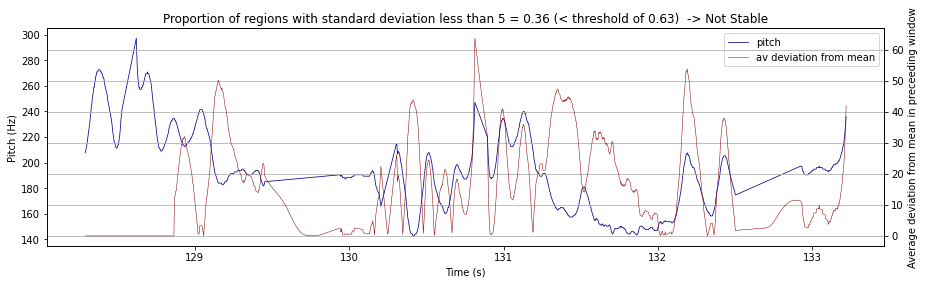

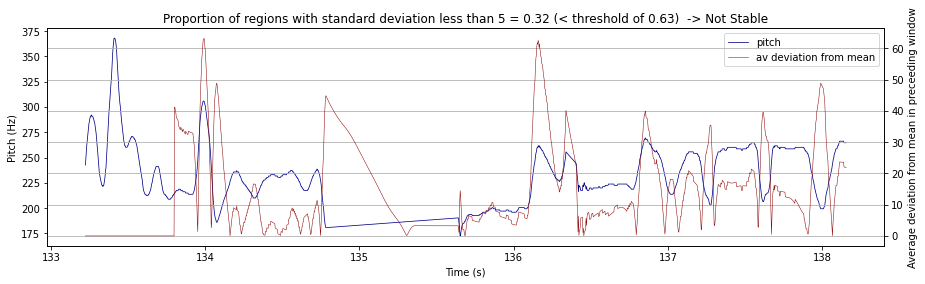

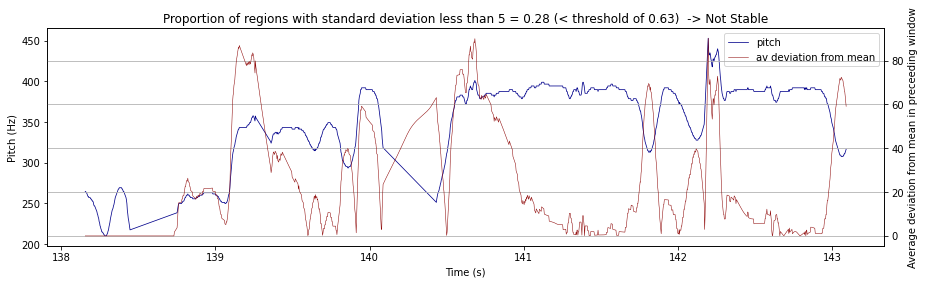

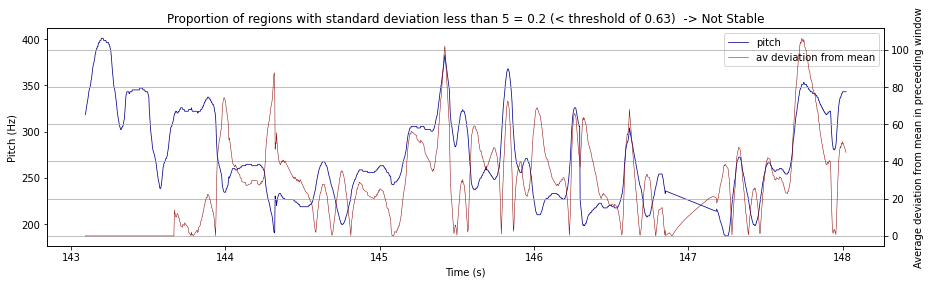

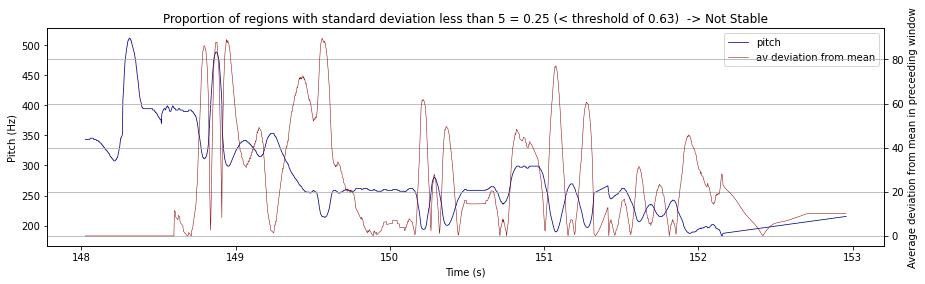

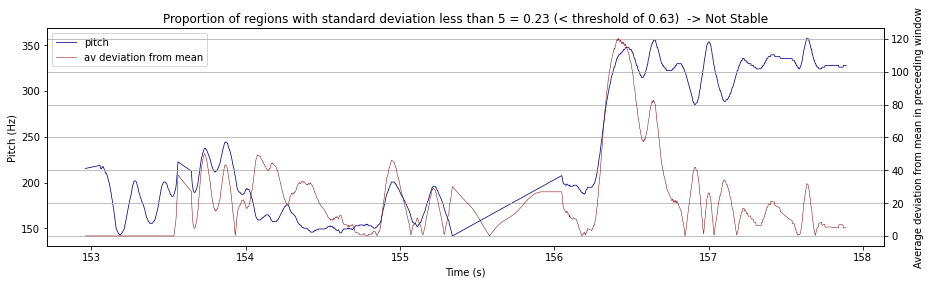

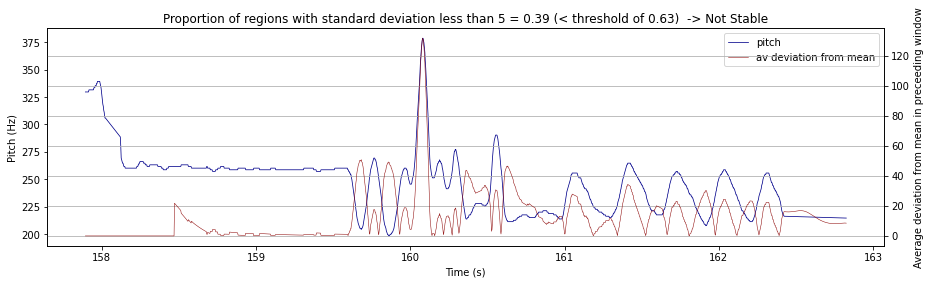

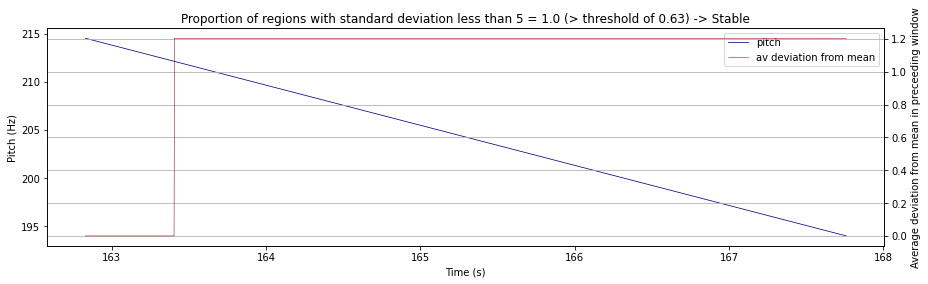

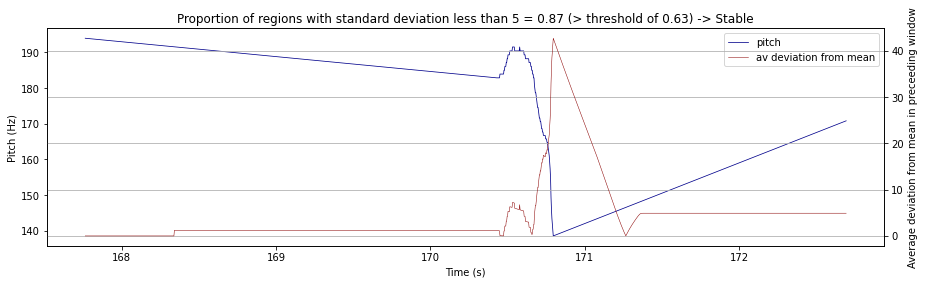

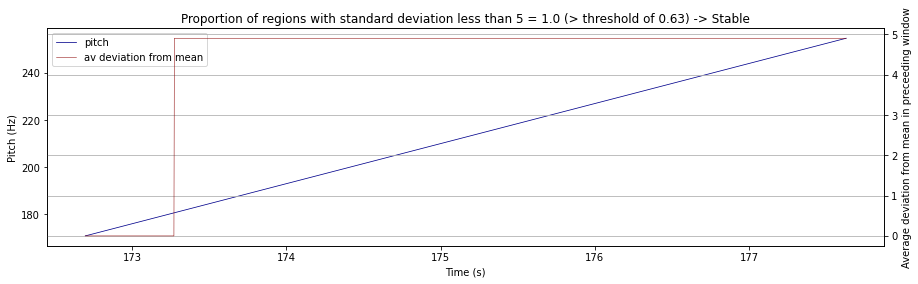

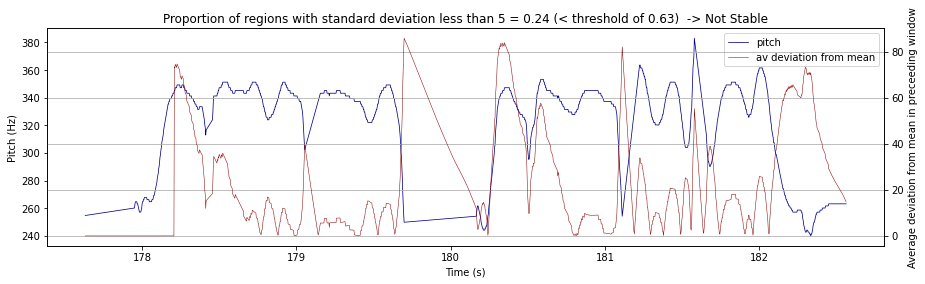

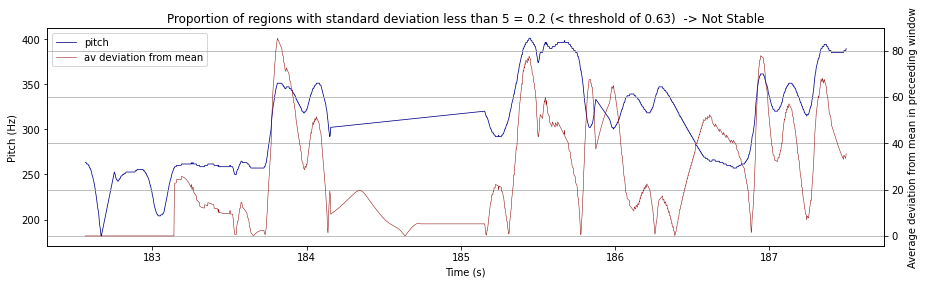

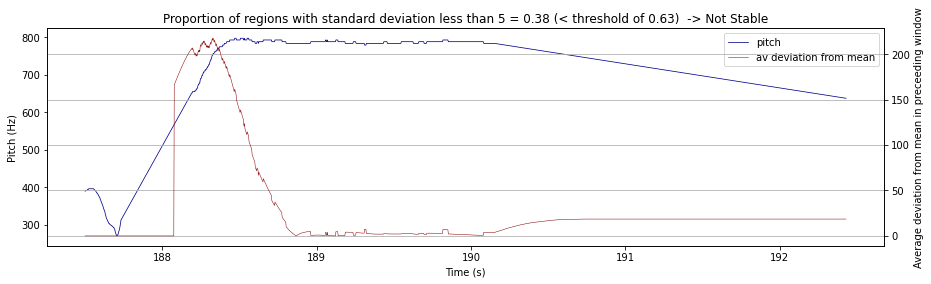

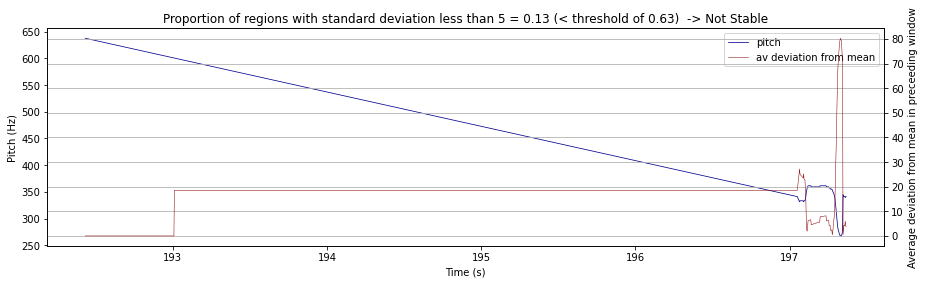

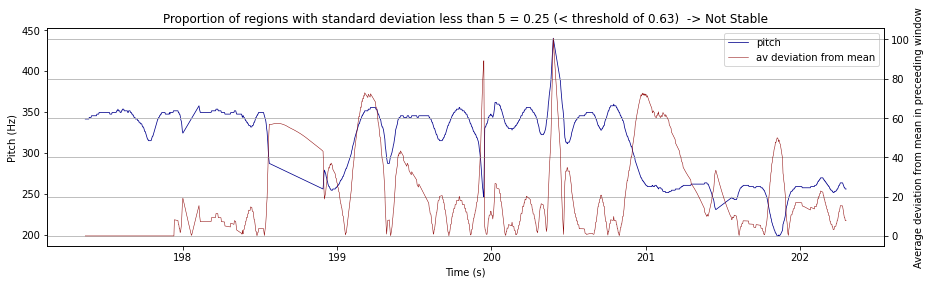

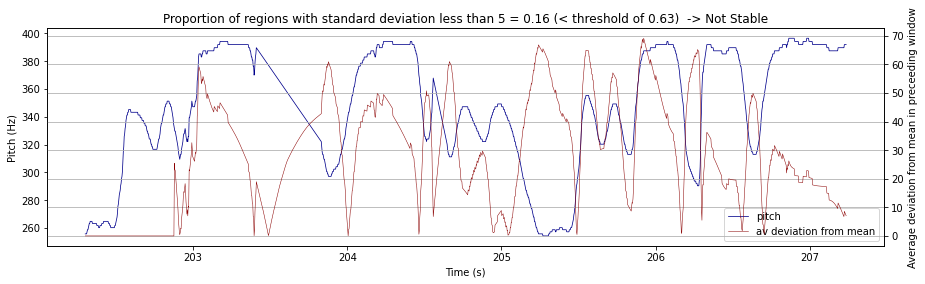

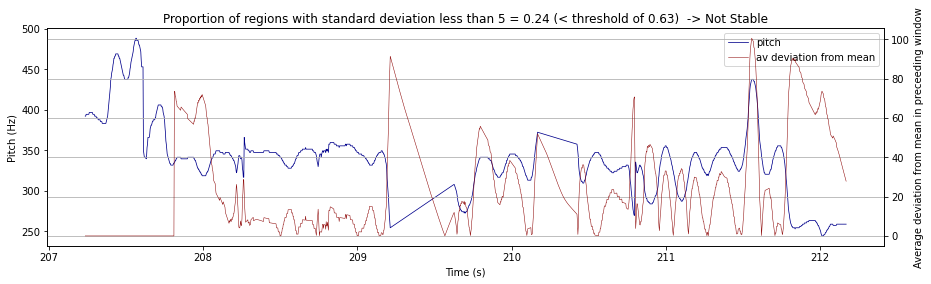

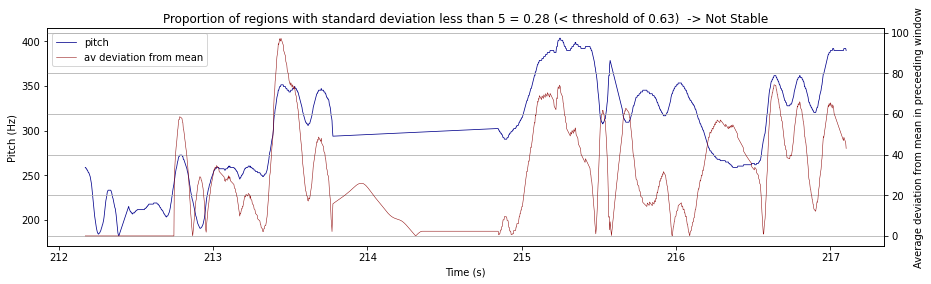

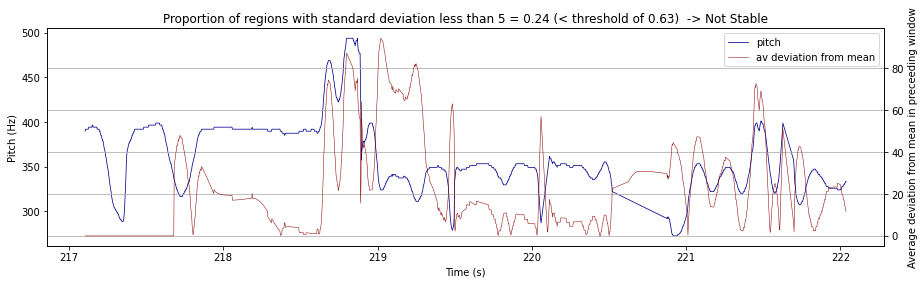

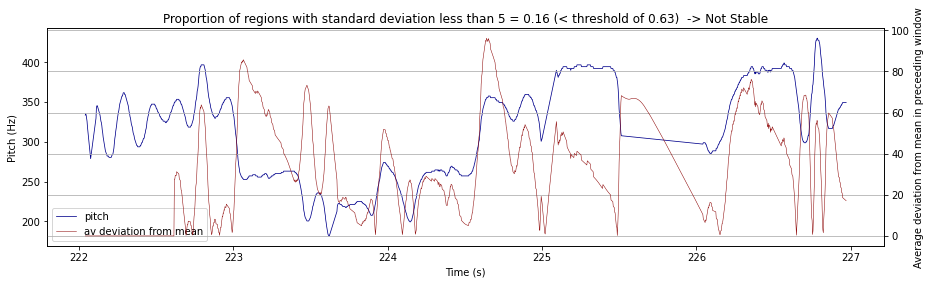

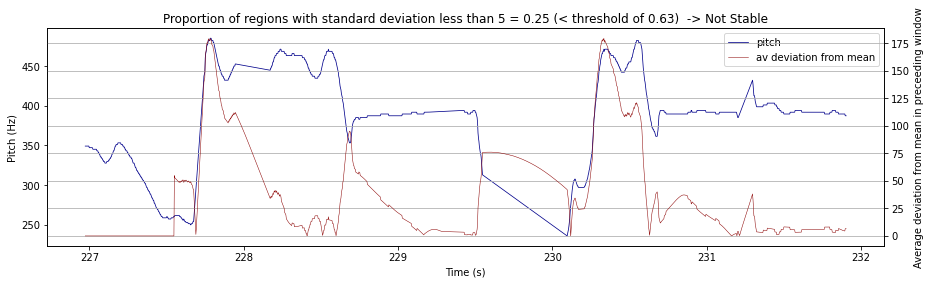

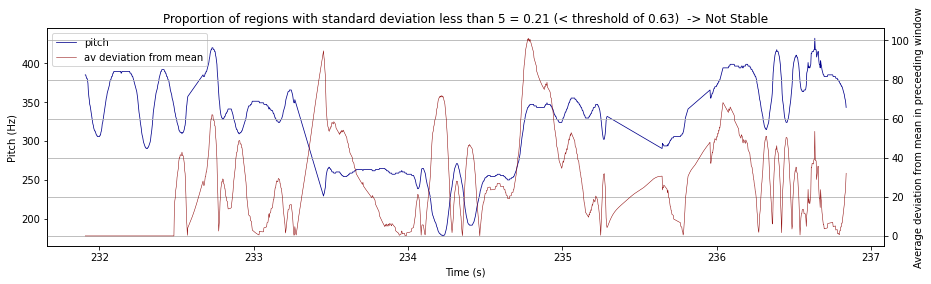

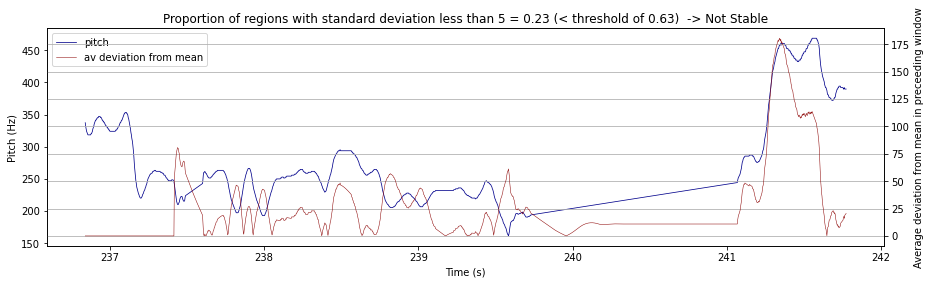

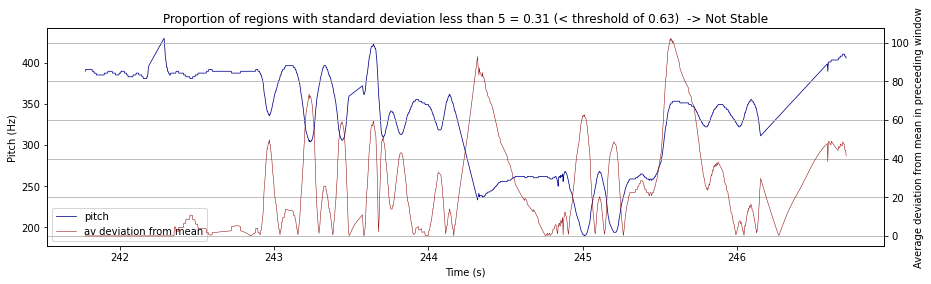

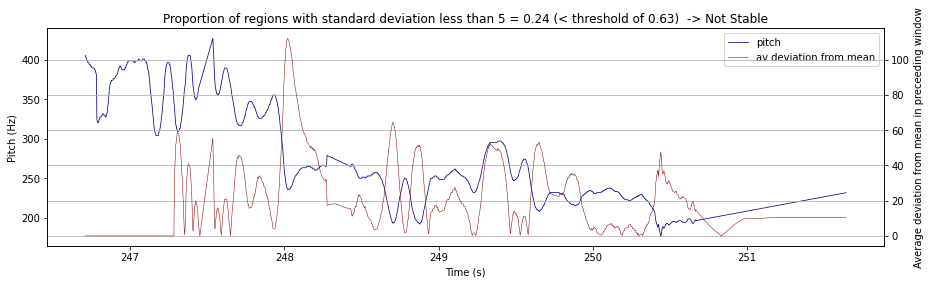

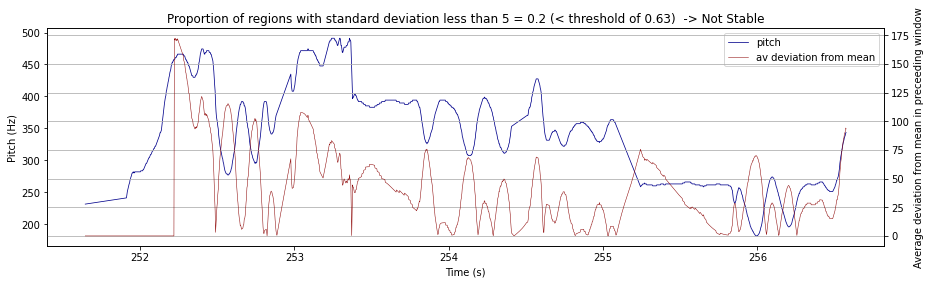

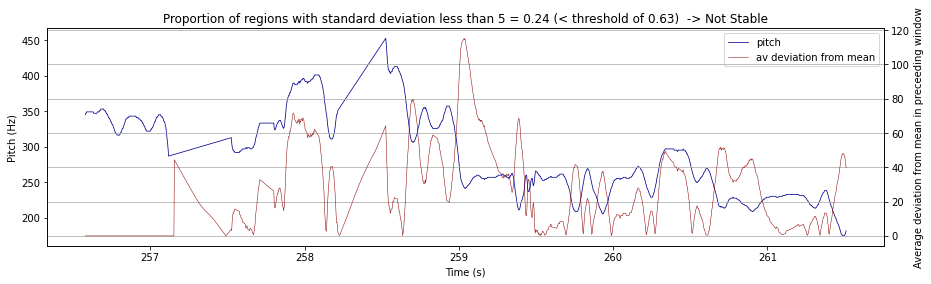

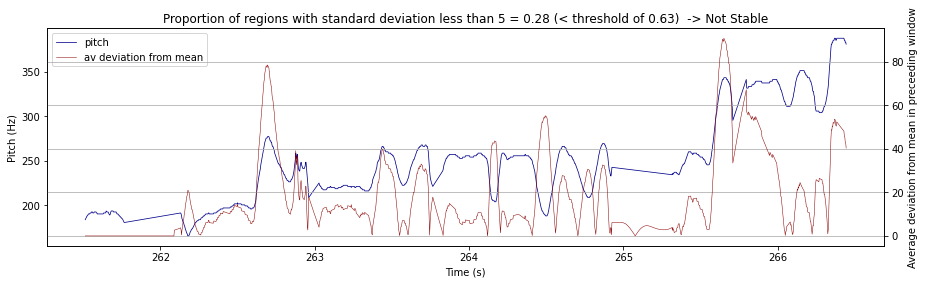

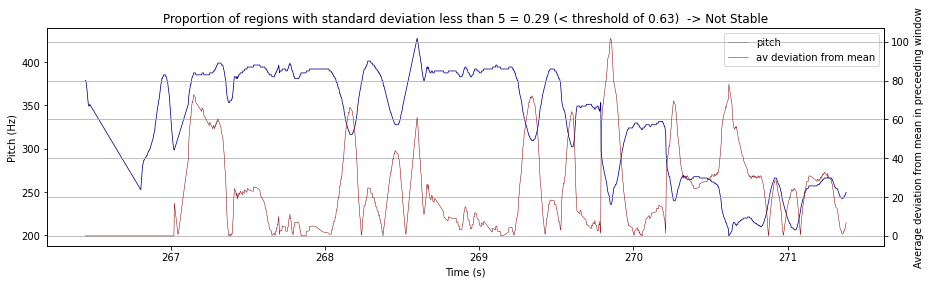

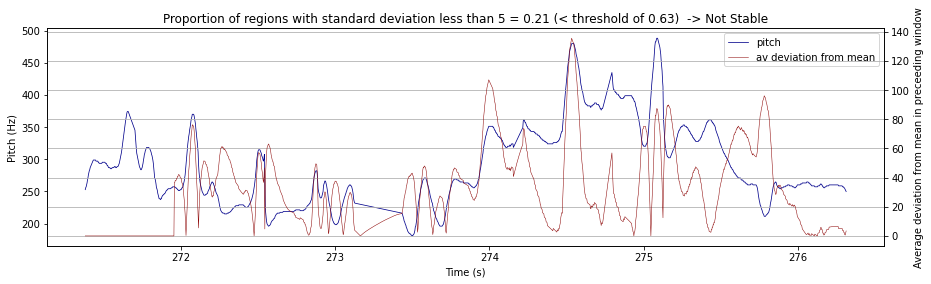

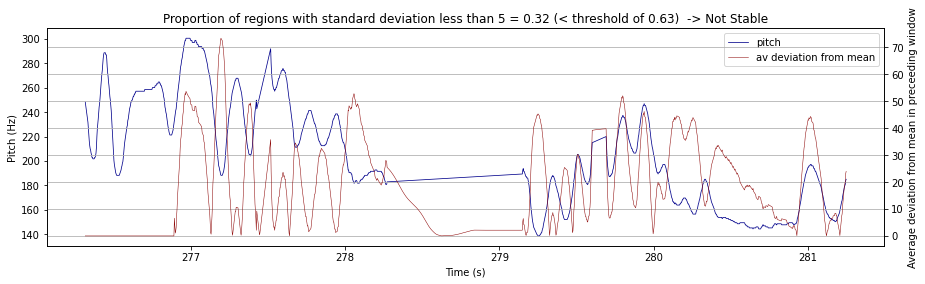

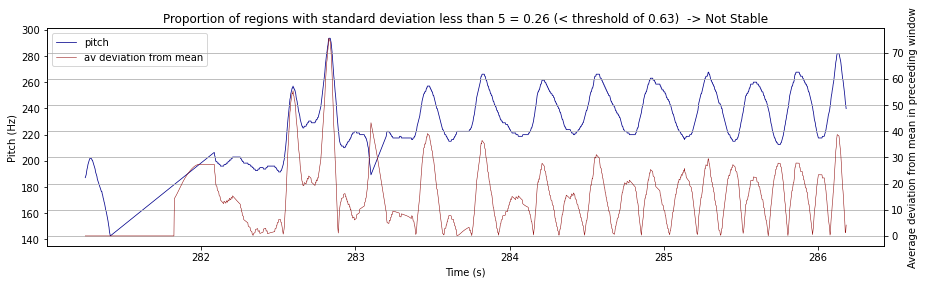

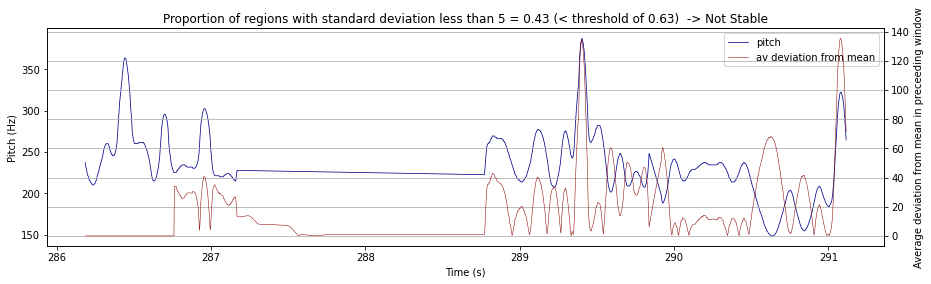

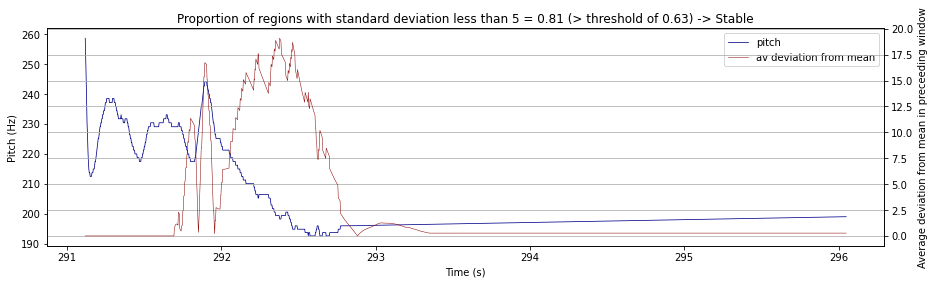

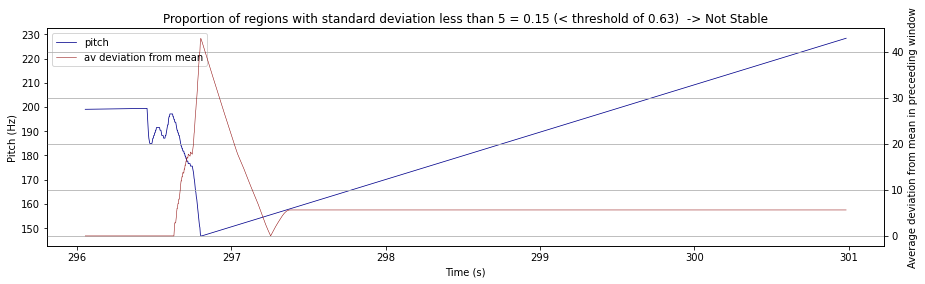

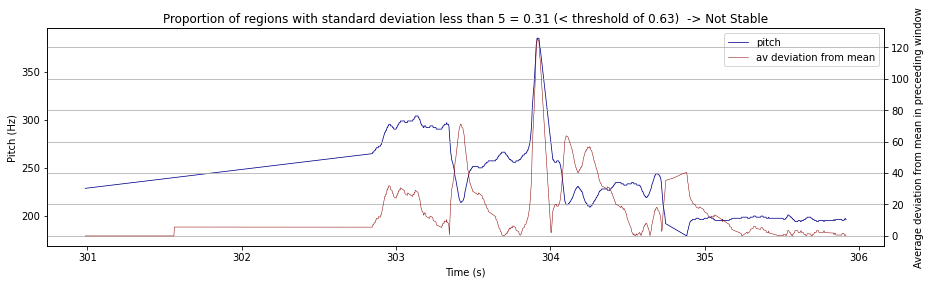

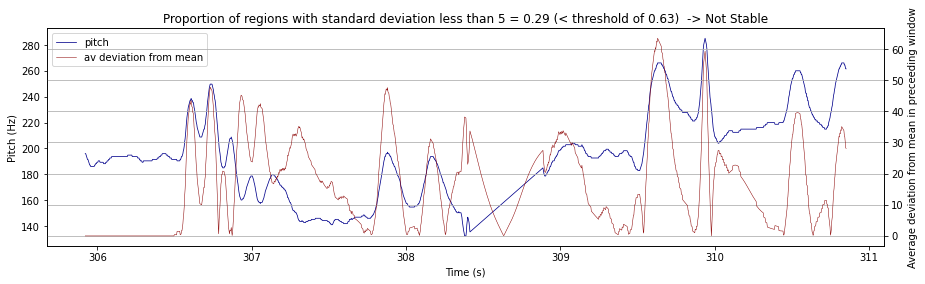

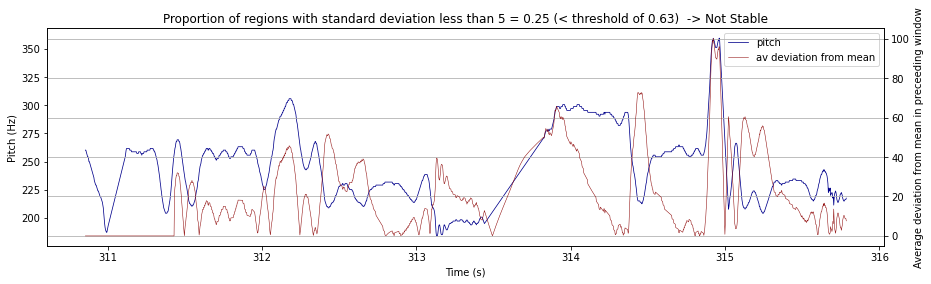

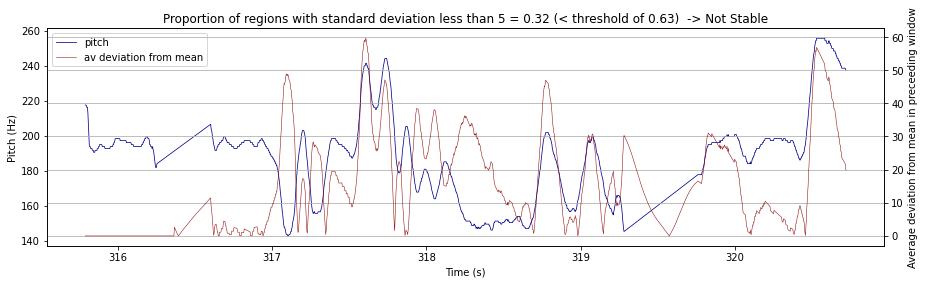

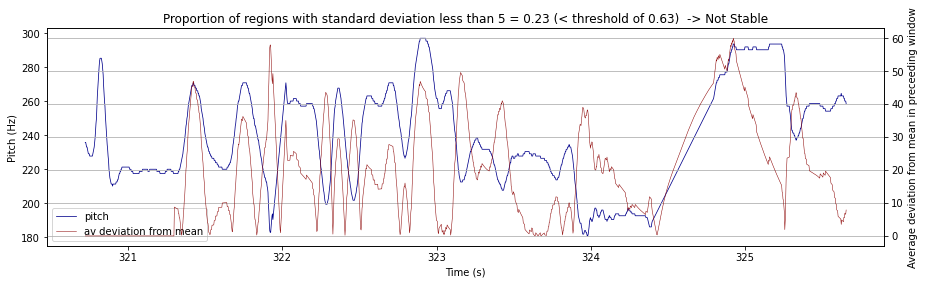

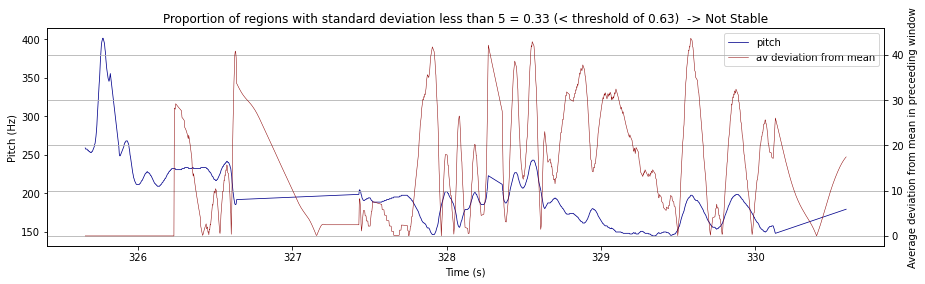

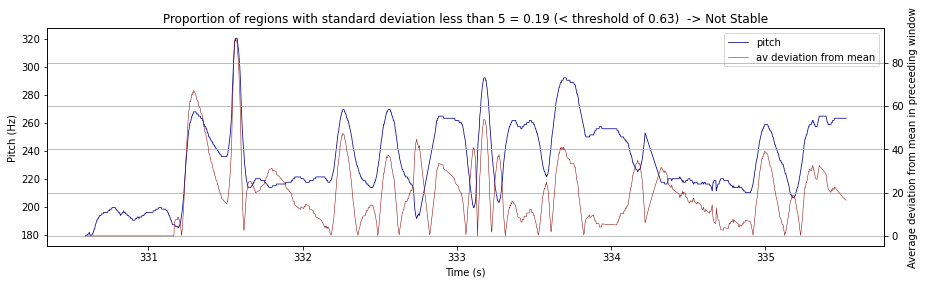

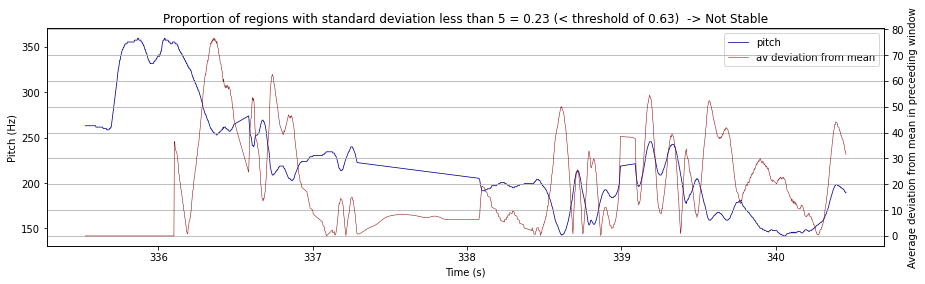

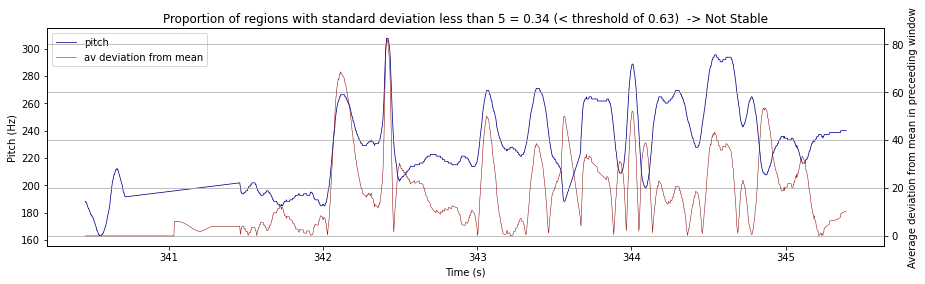

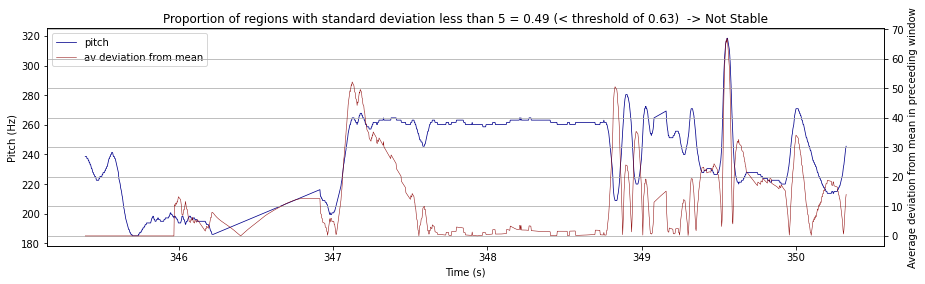

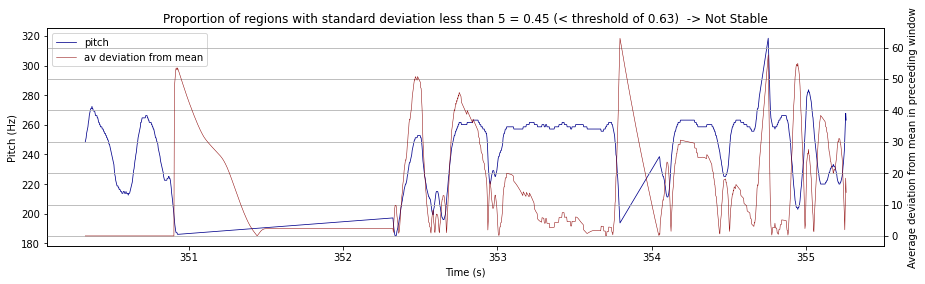

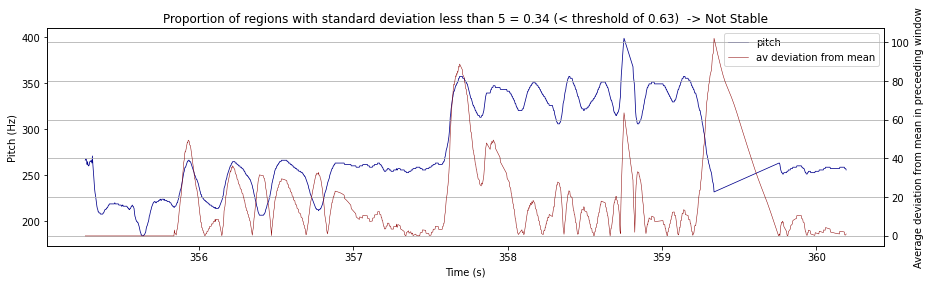

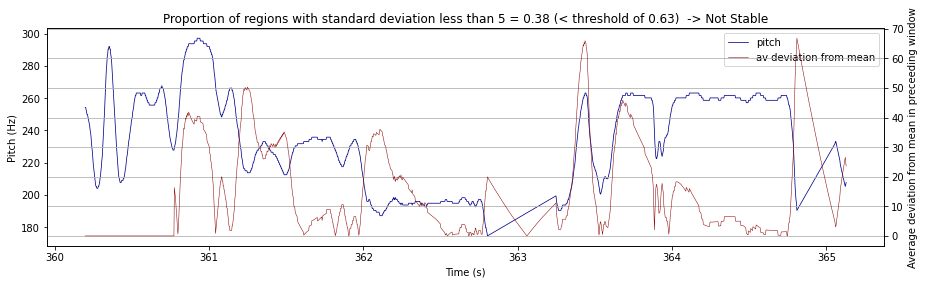

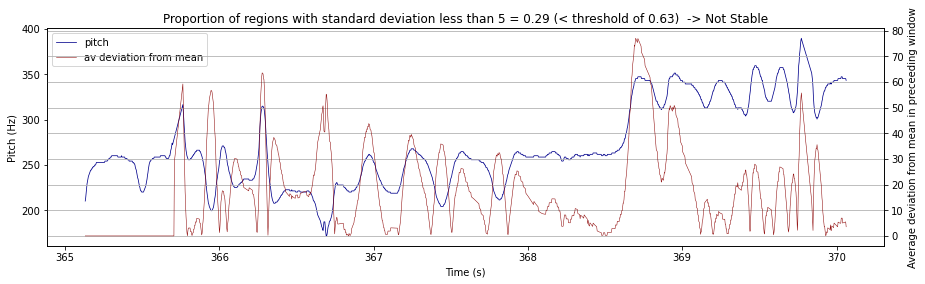

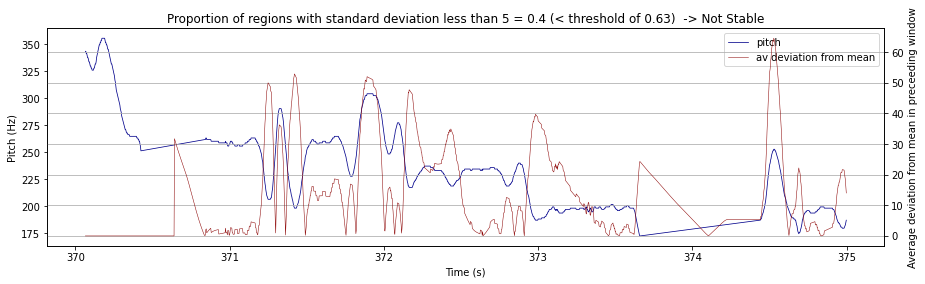

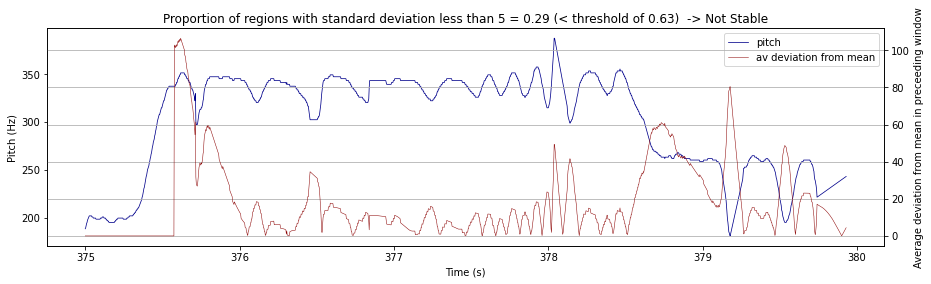

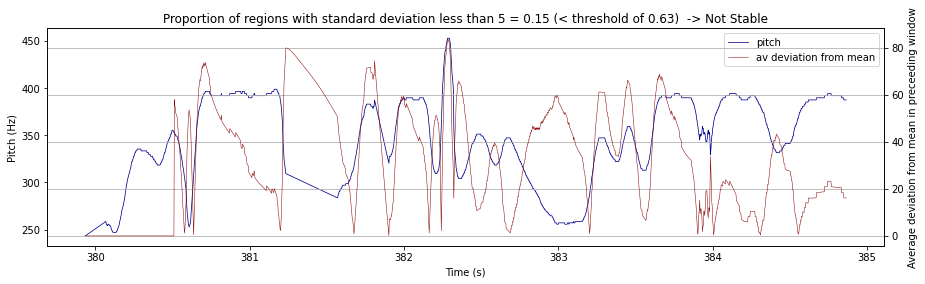

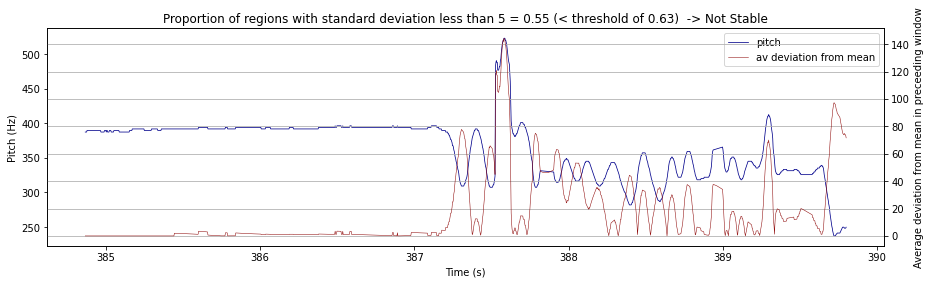

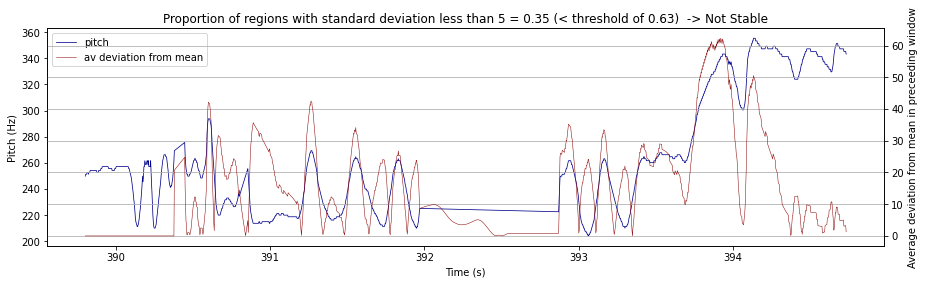

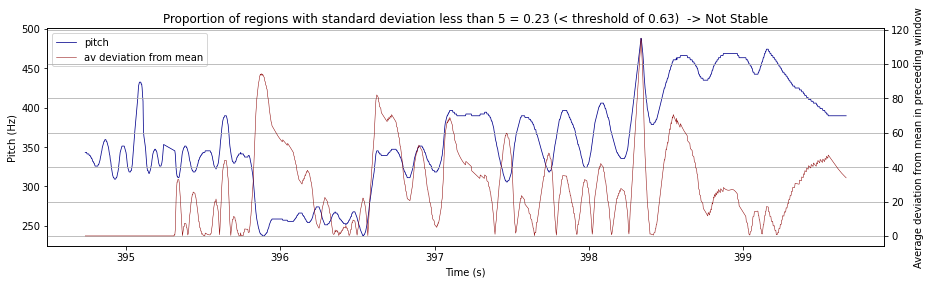

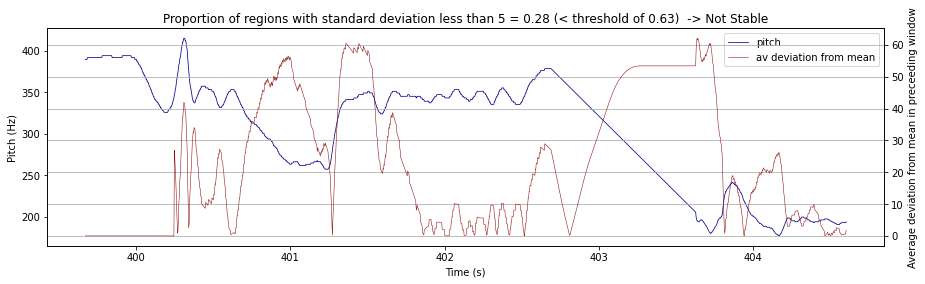

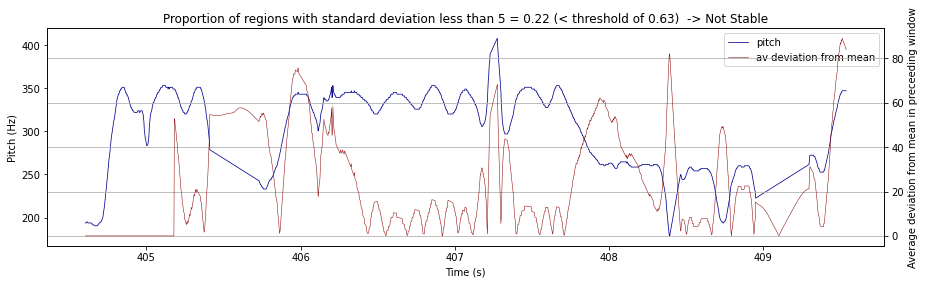

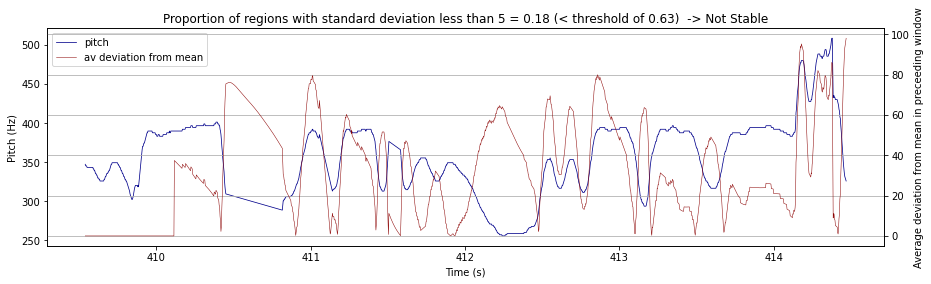

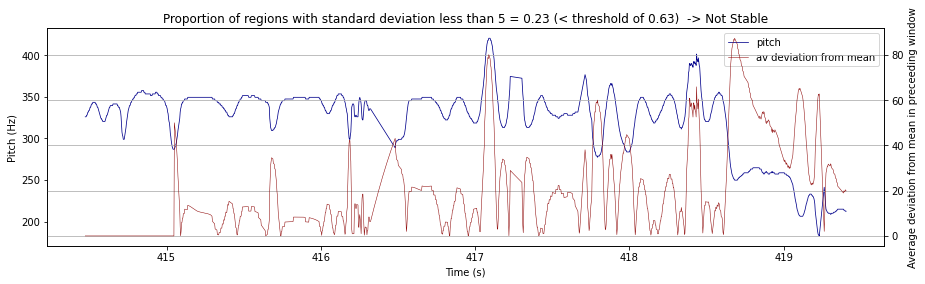

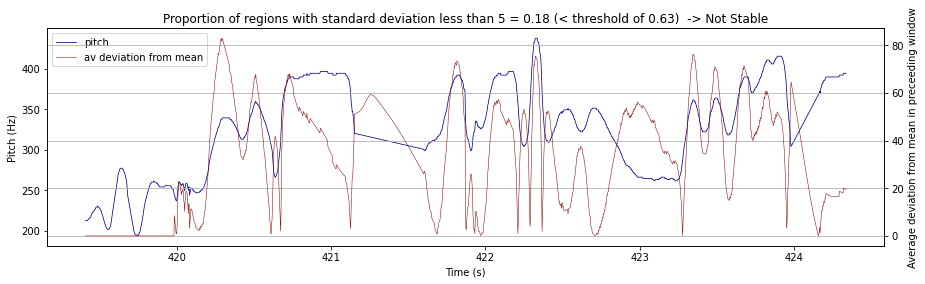

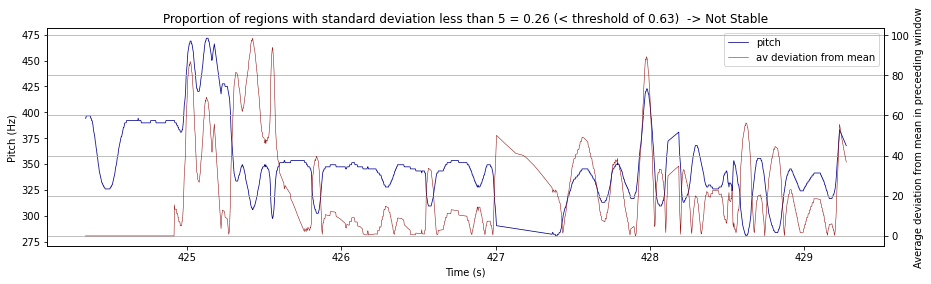

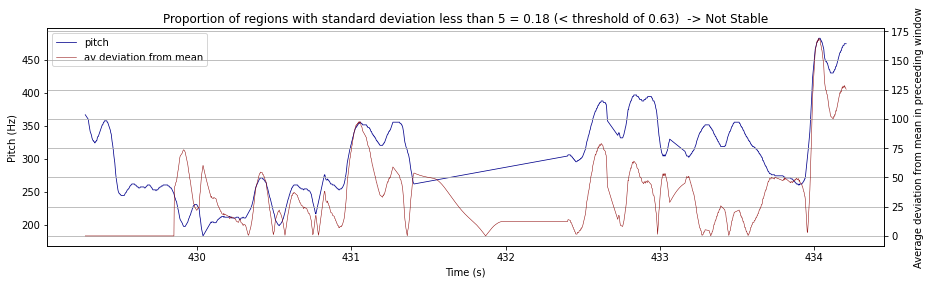

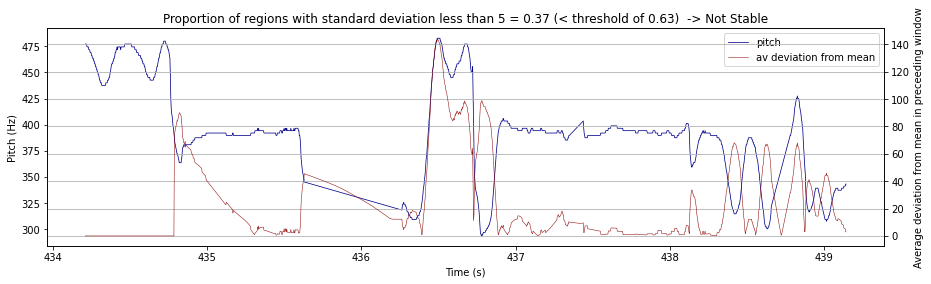

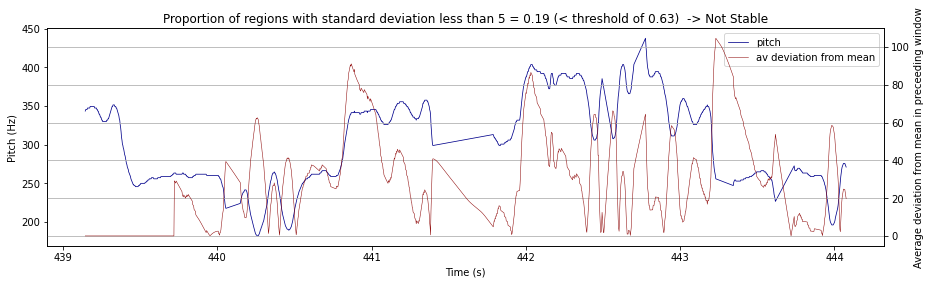

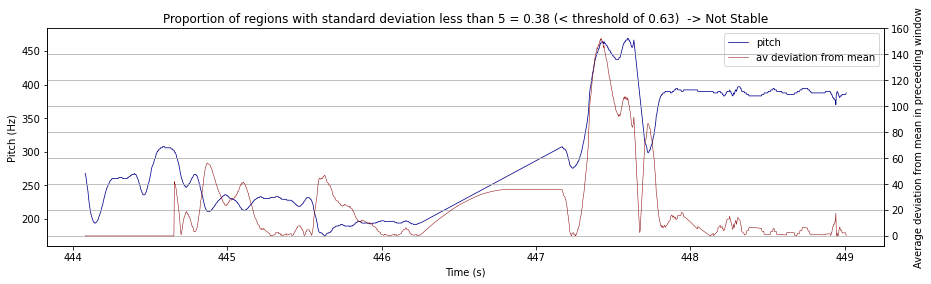

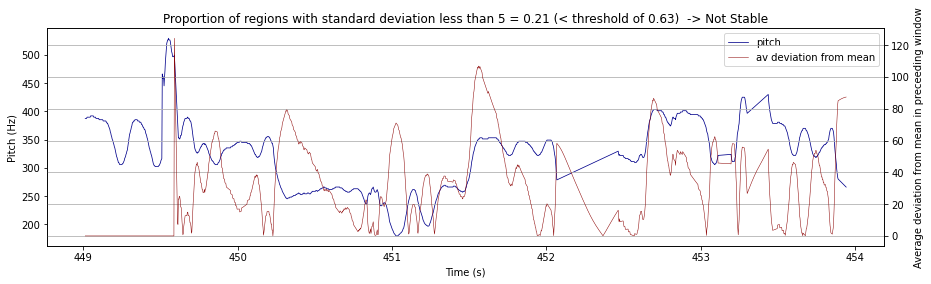

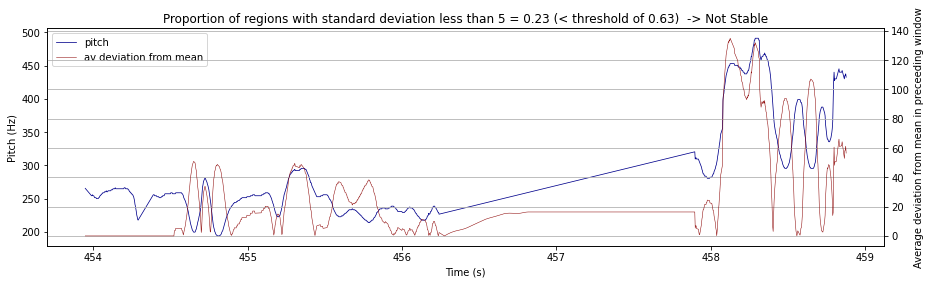

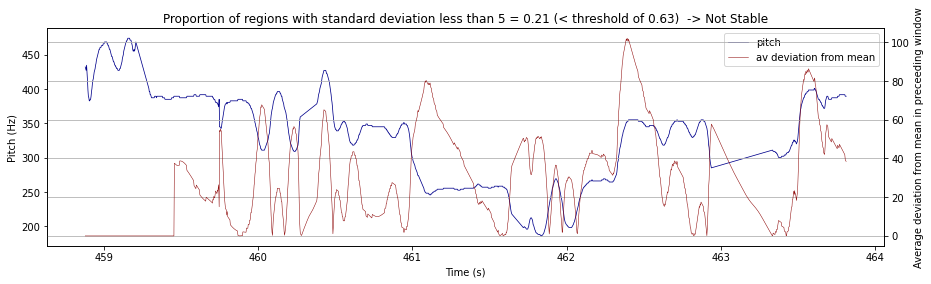

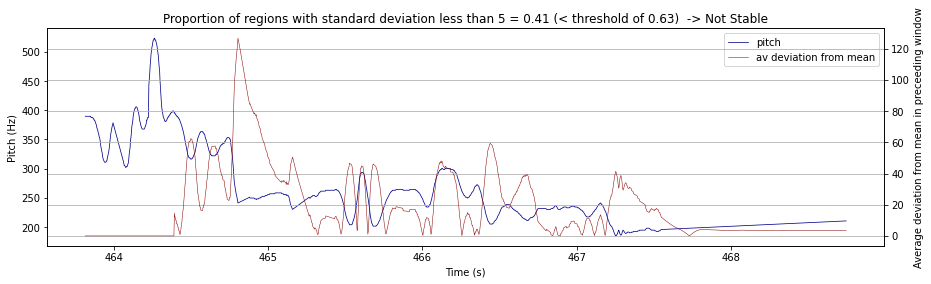

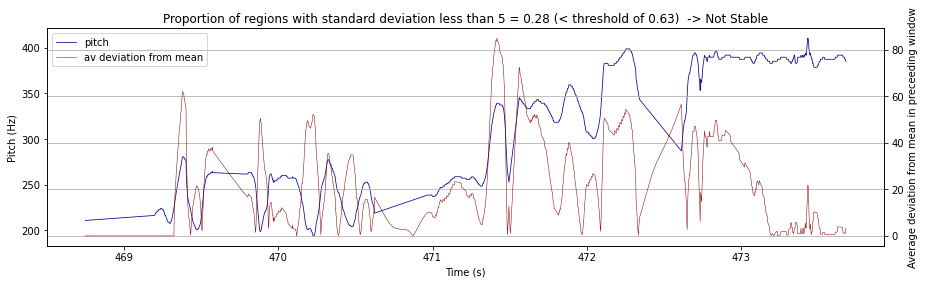

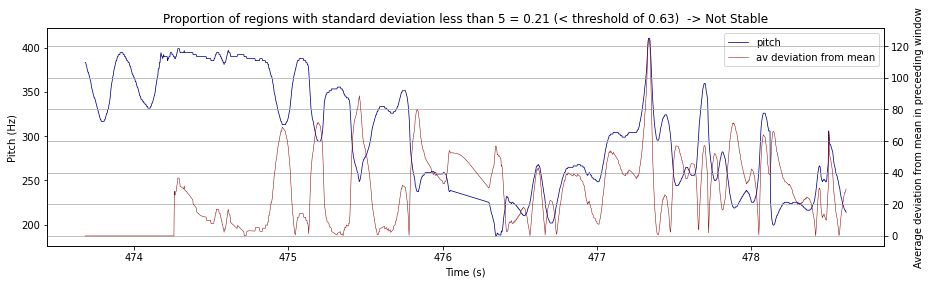

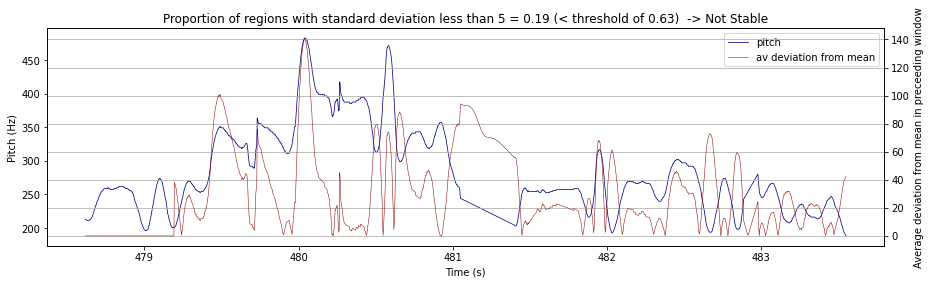

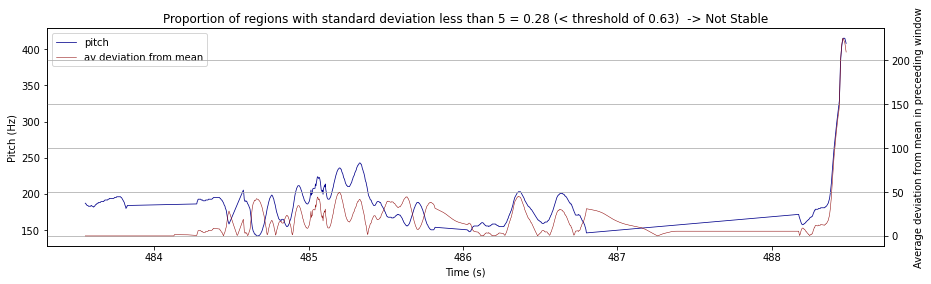

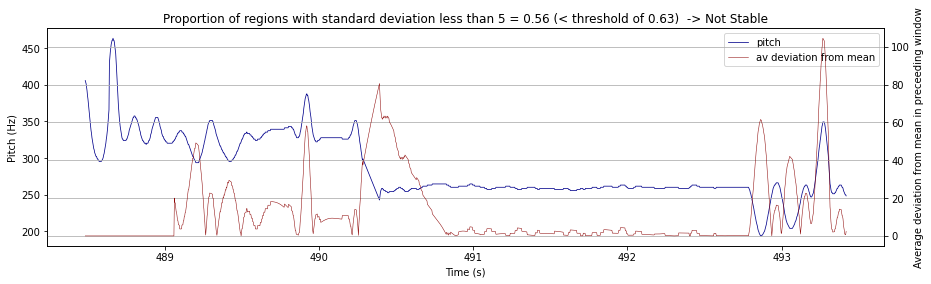

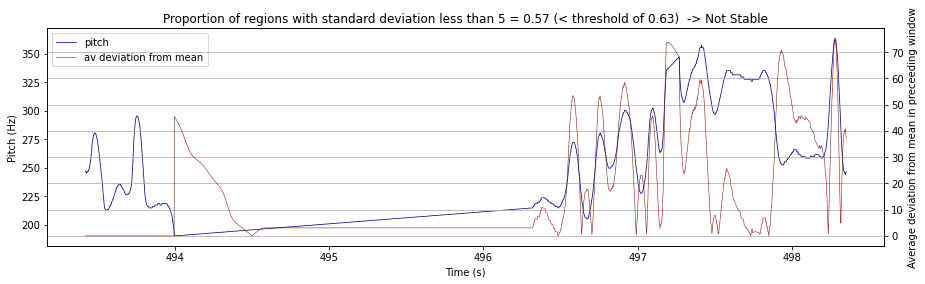

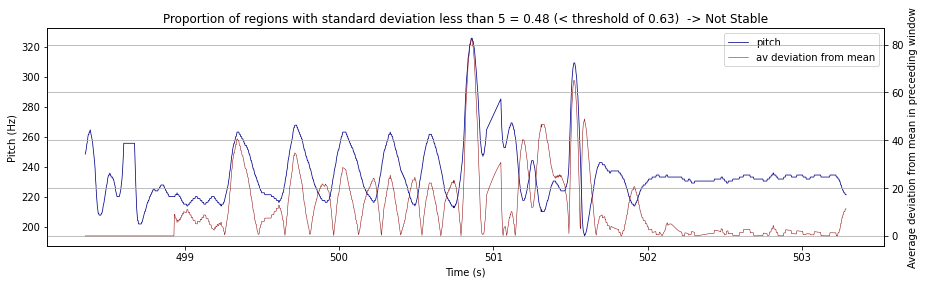

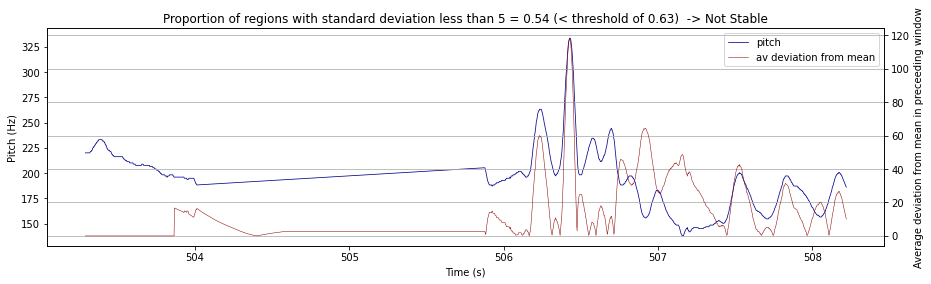

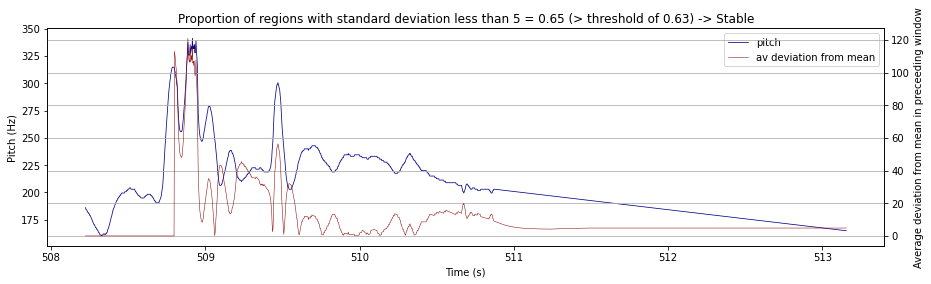

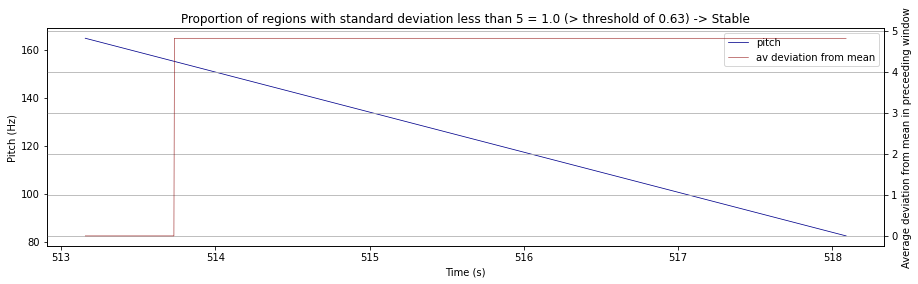

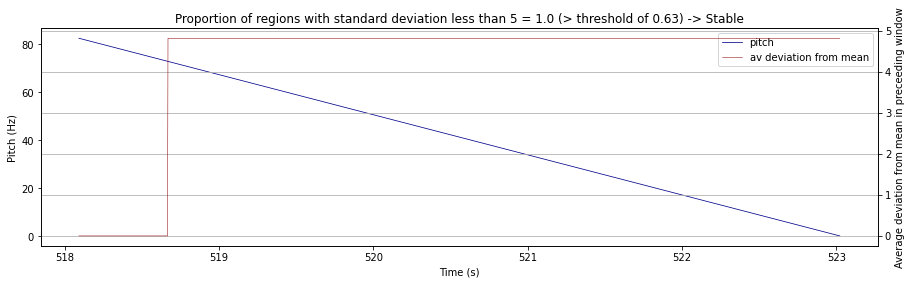

In [31]:
from src.sequence import moving_average


for z in np.arange(0, len(raw_pitch[:-l]), l):

    seq = raw_pitch[z:z+l]
    plot_seq = seq[:]
    plot_seq[np.where(plot_seq==0)] = np.nan
    tseq = time[z:z+l]


    if window > len(seq):
        window=len(seq)
        
    mu_ = seq[:window-1]
    mu = np.concatenate([mu_, moving_average(seq, window)])

    dev_arr = abs(mu-seq)
    dev_seq = dev_arr[np.where(~np.isnan(dev_arr))]
    bel_thresh = dev_seq < dev_thresh

    perc = np.count_nonzero(bel_thresh)/len(dev_seq)
    if perc >= perc_thresh:
        is_stable = 1
        title = f'Proportion of regions with average deviation less than {dev_thresh} = {round(perc,2)} (> threshold of {perc_thresh}) -> Stable'
    else:
        is_stable = 0
        title = f'Proportion of regions with average deviation less than {dev_thresh} = {round(perc,2)} (< threshold of {perc_thresh})  -> Not Stable'
    
    if True:#is_stable == 1:
        plt.figure(figsize=(15,4))
        ax1 = plt.gca()
        ax2 = ax1.twinx()

        ax1.plot(tseq, plot_seq, linewidth=0.75, color='darkblue', label='pitch')
        ax2.plot(tseq, dev_arr, linewidth=0.5, color='darkred', label='av deviation from mean')
        #ax2.set_ylim((0,5))
        plt.title(title)
        ax1.set_ylabel('Pitch (Hz)')
        ax1.set_xlabel('Time (s)')
        ax2.set_ylabel('Average deviation from mean in preceeding window')
        plt.grid()

    #   plt.axhline(dev_thresh)
        #t = 0
        #while t < len(seq):
        #    t1 = tseq[t]
        #    plt.axvline(t1, linestyle='--', linewidth=0.75, color='darkred')
        #    plt.annotate(round(dev_arr[t],5), (t1+0.05,max(seq)-80), rotation=90, color='darkred')
        #    t += window
        lines = ax1.get_lines() + ax2.get_lines()
        ax1.legend(lines, [line.get_label() for line in lines], loc='best')
        plt.show()
        plt.close('all')